In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import time
import os
import torch.nn as nn
import torch
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence
from preprocessing_util import preposs_toekn, Lang, text2index, construct_Lang
from Multilayers_Encoder import EncoderRNN
from Multilayers_Decoder import DecoderRNN, DecoderAtten
#from config import device, PAD_token, SOS_token, EOS_token, UNK_token, embedding_freeze, vocab_prefix
import random
from evaluation import evaluate_batch, evaluate_beam_batch
import pickle 
from config import *

In [3]:
model_address = '/scratch/xq303/NLP/Machine_Translation_NLP/vi-en-dot-1wVocab_12_sum_beam_dropout1/epoch_9.pth'
config_address = '/scratch/xq303/NLP/Machine_Translation_NLP/vi-en-dot-1wVocab_12_sum_beam_dropout1/model_params.pkl'
transtype = ('vi', 'en')
check_point_state = torch.load(model_address)
with open(config_address, 'rb') as f:
    paras = pickle.load(f)

In [4]:
src_max_vocab_size = paras['src_max_vocab_size']
tgt_max_vocab_size = paras['tgt_max_vocab_size']
tgt_max_len = paras['tgt_max_len']
max_src_len_dataloader = paras['max_src_len_dataloader']
max_tgt_len_dataloader = paras['max_tgt_len_dataloader']

teacher_forcing_ratio = paras['teacher_forcing_ratio']
emb_size = paras['emb_size']
hidden_size = paras['hidden_size']
num_layers = paras['num_layers']
num_direction = paras['num_direction']
deal_bi = paras['deal_bi']
learning_rate = paras['learning_rate']
num_epochs = paras['num_epochs']
batch_size = paras['batch_size']
attention_type = paras['attention_type']
rnn_type = 'LSTM'
beam_size = paras['beam_size']
model_save_info = paras['model_save_info']
dropout_rate = paras['dropout_rate']

# address_book=dict(
#     train_src = 'Machine_Translation_NLP/iwsltzhen/iwslt-{}-{}/train.tok.{}'.format(transtype[0], transtype[1], transtype[0]),
#     train_tgt = 'Machine_Translation_NLP/iwsltzhen/iwslt-{}-{}/train.tok.{}'.format(transtype[0], transtype[1], transtype[1]),
#     val_src = 'Machine_Translation_NLP/iwsltzhen/iwslt-{}-{}/dev.tok.{}'.format(transtype[0], transtype[1], transtype[0]),
#     val_tgt = 'Machine_Translation_NLP/iwsltzhen/iwslt-{}-{}/dev.tok.{}'.format(transtype[0], transtype[1], transtype[1]),
#     src_emb = 'embedding/wiki.{}.vec'.format(transtype[0]),
#     tgt_emb = 'embedding/wiki.{}.vec'.format(transtype[1])
#     )
#print(address_book)
train_src_add = address_book['train_src']
train_tgt_add = address_book['train_tgt']
val_src_add = address_book['val_src']
val_tgt_add = address_book['val_tgt']

# make dir for saving models
if not os.path.exists(model_save_info['model_path']):
    os.makedirs(model_save_info['model_path'])
### save model hyperparameters
with open(model_save_info['model_path']+'model_params.pkl', 'wb') as f:
    model_hyparams = paras
    model_hyparams['address_book'] = address_book
    pickle.dump(model_hyparams, f)
print(model_hyparams)

train_src = []
with open(train_src_add) as f:
    for line in f:
        train_src.append(preposs_toekn(line[:-1].strip().split(' ')))

train_tgt = []
with open(train_tgt_add) as f:
    for line in f:
        train_tgt.append(preposs_toekn(line[:-1].strip().split(' ')))

val_src = []
with open(val_src_add) as f:
    for line in f:
        val_src.append(preposs_toekn(line[:-1].strip().split(' ')))

val_tgt = []
with open(val_tgt_add) as f:
    for line in f:
        val_tgt.append(preposs_toekn(line[:-1].strip().split(' ')))

print('The number of train samples: ', len(train_src))
print('The number of val samples: ', len(val_src))
srcLang = construct_Lang('src', src_max_vocab_size, address_book['src_emb'], train_src)
tgtLang = construct_Lang('tgt', tgt_max_vocab_size, address_book['tgt_emb'], train_tgt)
#train_input_index = text2index(train_src, srcLang.word2index) #add EOS token here 
#train_output_index = text2index(train_tgt, tgtLang.word2index)
val_input_index = text2index(val_src, srcLang.word2index)
val_output_index = text2index(val_tgt, tgtLang.word2index)

{'src_max_vocab_size': 26109, 'tgt_max_vocab_size': 10000, 'tgt_max_len': 100, 'max_src_len_dataloader': 72, 'max_tgt_len_dataloader': 71, 'emb_size': 300, 'hidden_size': 256, 'num_layers': 1, 'num_direction': 2, 'deal_bi': 'sum', 'rnn_type': 'LSTM', 'attention_type': 'dot_prod', 'teacher_forcing_ratio': 1, 'learning_rate': 0.001, 'num_epochs': 22, 'batch_size': 128, 'beam_size': 5, 'dropout_rate': 0.1, 'model_save_info': {'model_path': 'nmt_models/vi-en-dot-1wVocab_12_sum_beam_dropout1/', 'epochs_per_save_model': 1, 'model_path_for_resume': None}, 'address_book': {'train_src': '/scratch/xq303/NLP/Machine_Translation_NLP/sorttoken/val_sortByEn.tok.vi_short', 'train_tgt': '/scratch/xq303/NLP/Machine_Translation_NLP/sorttoken/val_sortByEn.tok.vi.en_short', 'val_src': '/scratch/xq303/NLP/Machine_Translation_NLP/sorttoken/val_sortByEn.tok.vi_mid', 'val_tgt': '/scratch/xq303/NLP/Machine_Translation_NLP/sorttoken/val_sortByEn.tok.vi.en_mid', 'src_emb': '/scratch/xq303/NLP/embedding/wiki.vi.v

In [5]:
if paras["attention_type"]:
    encoder = EncoderRNN(srcLang.vocab_size, emb_size, hidden_size, num_layers, num_direction, deal_bi, rnn_type = rnn_type, embedding_weight = None, dropout_rate = dropout_rate)
    decoder = DecoderAtten(emb_size, hidden_size, tgtLang.vocab_size, num_layers, rnn_type = rnn_type, embedding_weight = None, atten_type = attention_type, dropout_rate = dropout_rate)
else:      
    encoder = EncoderRNN(srcLang.vocab_size, emb_size,hidden_size, num_layers, num_direction, deal_bi, rnn_type = rnn_type, embedding_weight = None, dropout_rate = dropout_rate)
    decoder = DecoderRNN(emb_size, hidden_size, tgtLang.vocab_size, num_layers, rnn_type = rnn_type, embedding_weight = None, dropout_rate = dropout_rate)
    

dot_prod


/home/xq303/py3.6.3/lib/python3.6/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [6]:
encoder.load_state_dict(check_point_state['encoder_state_dict'])
decoder.load_state_dict(check_point_state['decoder_state_dict'])

RuntimeError: Error(s) in loading state_dict for EncoderRNN:
	size mismatch for embedding.weight: copying a param of torch.Size([1169, 300]) from checkpoint, where the shape is torch.Size([26113, 300]) in current model.

In [ ]:
from Data_utils import VocabDataset, vocab_collate_func

In [ ]:
val_dataset = VocabDataset(val_input_index,val_output_index, None, None)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                        batch_size=1,
                                        collate_fn=vocab_collate_func,
                                        shuffle=False)

In [22]:
encoder, decoder = encoder.to(device), decoder.to(device)

In [23]:
# criterion = nn.NLLLoss()
# val_bleu_sacre, val_bleu_nltk, val_loss = evaluate_batch(val_loader, encoder, decoder, criterion, tgt_max_len, tgtLang.index2word, srcLang.index2word)


In [221]:
import sacrebleu
import beam
def fun_index2token(index_list, idx2words):
    token_list = []
    for index in index_list:
        if index == EOS_token:
            break
        else:
            token_list.append(idx2words[index])
    return token_list

def visulization(loader, encoder, decoder, tgt_max_length, tgt_idx2words, src_idx2words):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")    
    tgt_sents_sacre = []
    tgt_pred_sents_sacre = []
    src_sents = []
    atten_weight_list = []
    true_prob_list = []
    pred_prob_list = []
    with torch.no_grad():
        for input_tensor, input_lengths, target_tensor, target_lengths in loader:
            atten_weights = []
            true_prob = []
            pred_prob = []
            batch_size = input_tensor.size(0)
            encoder_hidden, encoder_cell = encoder.initHidden(batch_size)
            encoder_outputs, encoder_hidden, encoder_cell = encoder(input_tensor, encoder_hidden, input_lengths, encoder_cell)
            decoder_input = torch.tensor([[SOS_token]*batch_size], device=device).transpose(0,1)
            decoder_hidden = encoder_hidden
            decoder_cell = encoder_cell
            decoding_token_index = 0
            target_lengths_numpy = target_lengths.cpu().numpy()
            idx_token_pred = np.zeros((batch_size, tgt_max_length), dtype=np.int)
            while decoding_token_index < tgt_max_length:
                decoder_output, decoder_hidden, weight,decoder_cell = decoder(decoder_input, decoder_hidden, input_lengths, encoder_outputs,decoder_cell)  
                if decoding_token_index < target_tensor.size(1):
                    true_index = target_tensor[0,decoding_token_index].cpu().item()
                    true_prob.append(decoder_output[0,true_index])
                atten_weights.append(np.array(weight.squeeze(0).squeeze(0)))
                topv, topi = decoder_output.topk(1)
                pred_prob.append(topv.detach().squeeze().cpu().item())
                decoder_input = topi.detach()  # detach from history as input
                idx_token_pred_step = decoder_input.cpu().squeeze(1).numpy()
                idx_token_pred[:, decoding_token_index] = idx_token_pred_step
                decoding_token_index += 1
                end_or_not = idx_token_pred_step != EOS_token
                sent_not_end_index = list(np.where(end_or_not)[0])
                if len(sent_not_end_index) == 0:
                    break
            pred_prob_list.append(pred_prob)
            true_prob_list.append(true_prob)
            atten_weight_list.append(atten_weights)
            target_tensor_numpy = target_tensor.cpu().numpy()
            input_tensor_numpy = input_tensor.cpu().numpy()
            for i_batch in range(batch_size):
                tgt_sent_tokens = fun_index2token(target_tensor_numpy[i_batch].tolist(), tgt_idx2words) #:target_lengths_numpy[i_batch]
                tgt_sents_sacre.append(' '.join(tgt_sent_tokens))
                tgt_pred_sent_tokens = fun_index2token(idx_token_pred[i_batch].tolist(), tgt_idx2words)
                tgt_pred_sents_sacre.append(' '.join(tgt_pred_sent_tokens))
                src_sent_tokens = fun_index2token(input_tensor_numpy[i_batch].tolist(), src_idx2words)
                src_sents.append(' '.join(src_sent_tokens))
    sacre_bleu_score = sacrebleu.corpus_bleu(tgt_pred_sents_sacre, [tgt_sents_sacre], smooth='exp', smooth_floor=0.0, force=False, lowercase=False,
        tokenize='none', use_effective_order=True)
    if True:
        random_sample = np.random.randint(len(tgt_pred_sents_sacre))
        print('src:', src_sents[random_sample])
        print('Ref: ', tgt_sents_sacre[random_sample])
        print('pred: ', tgt_pred_sents_sacre[random_sample])
        print('sacre_bleu_score',sacre_bleu_score)
    return src_sents, tgt_sents_sacre, tgt_pred_sents_sacre, atten_weight_list,true_prob_list,pred_prob_list


In [222]:
src_sents, tgt_sents_sacre, tgt_pred_sents_sacre, atten_weight_list,true_prob_list,pred_prob_list = visulization(val_loader, encoder, decoder, tgt_max_len, tgtLang.index2word, srcLang.index2word)


src: Ngày tôi trả_lại hình cho cô ấy cũng là ngày của đứa con_trai út của cô tròn 14 tuổi .
Ref:  The day I gave her the photos also happened to be her youngest son &apos;s <UNK> birthday .
pred:  Her day back back to her photographic son , was 14 of the youngest son of <UNK> .
sacre_bleu_score BLEU(score=23.53274954002384, counts=[15415, 7708, 4173, 2322], totals=[26234, 24966, 23698, 22432], precisions=[58.759624914233434, 30.87398862452936, 17.609080935100007, 10.351283880171184], bp=0.9813456614391619, sys_len=26234, ref_len=26728)


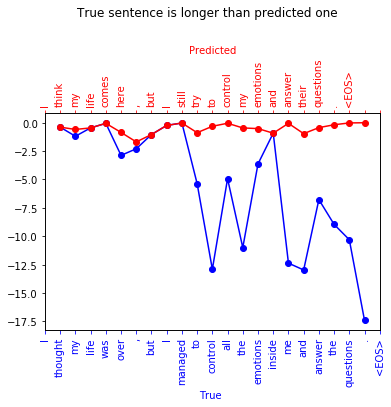

In [432]:
#true 长
fig, ax2 = plt.subplots()
ax1 = ax2.twiny()

idx = 33
ax1.plot(pred_prob_list[idx],'ro')
ax1.plot(pred_prob_list[idx],'r')
ax1.set_xticklabels([' '] + tgt_pred_sents_sacre[idx].split(' ') +['<EOS>'], rotation=90)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.set_xlabel('Predicted', color='r')
ax1.tick_params('x', colors='r')

ax2.plot(np.array(true_prob_list[idx]),'b')
ax2.plot(np.array(true_prob_list[idx]),'bo')
ax2.set_xticklabels([' '] + tgt_sents_sacre[idx].split(' ')  +['<EOS>'], rotation=90)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax2.set_xlabel('True ', color='b')
ax2.tick_params('x', colors='b')
plt.suptitle("True sentence is longer than predicted one", y=1.25)
plt.show()

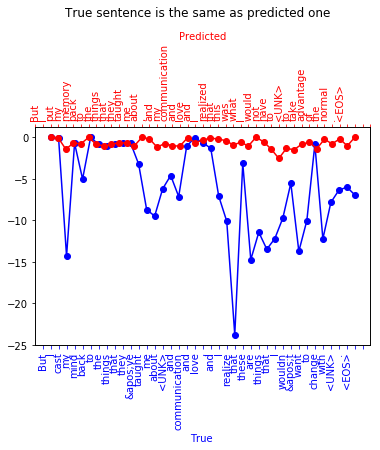

In [433]:
#一样长
fig, ax2 = plt.subplots()
ax1 = ax2.twiny()

idx = 121
ax1.plot(pred_prob_list[idx],'ro')
ax1.plot(pred_prob_list[idx],'r')
ax1.set_xticklabels([' '] + tgt_pred_sents_sacre[idx].split(' ') +['<EOS>'], rotation=90)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.set_xlabel('Predicted', color='r')
ax1.tick_params('x', colors='r')
ax2.plot(np.array(true_prob_list[idx]),'b')
ax2.plot(np.array(true_prob_list[idx]),'bo')
ax2.set_xticklabels([' '] + tgt_sents_sacre[idx].split(' ')  +['<EOS>'], rotation=90)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax2.set_xlabel('True ', color='b')
ax2.tick_params('x', colors='b')
plt.suptitle("True sentence is the same as predicted one", y=1.3)
plt.show()

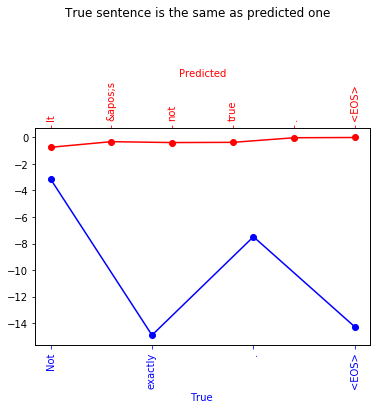

In [446]:
#predict 长
fig, ax2 = plt.subplots()
ax1 = ax2.twiny()

idx = 198
ax1.plot(pred_prob_list[idx],'ro')
ax1.plot(pred_prob_list[idx],'r')
ax1.set_xticklabels([' '] + tgt_pred_sents_sacre[idx].split(' ') +['<EOS>'], rotation=90)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.set_xlabel('Predicted', color='r')
ax1.tick_params('x', colors='r')
ax2.plot(np.array(true_prob_list[idx]),'b')
ax2.plot(np.array(true_prob_list[idx]),'bo')
ax2.set_xticklabels([' '] + tgt_sents_sacre[idx].split(' ')  +['<EOS>'], rotation=90)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax2.set_xlabel('True ', color='b')
ax2.tick_params('x', colors='b')
plt.suptitle("True sentence is the same as predicted one", y=1.3)
plt.show()

In [125]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [126]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

('Vì đó là lần đầu_tiên tôi biết rằng đồng_bào của tôi đang phải chịu_đựng như_vậy .',
 'Because it was the first time I knew my people was experiencing that .')

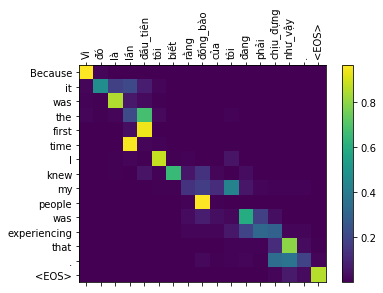

In [204]:
idx = 10
#index = [5,10,98,117]
aaa = np.array(atten_weight_list[idx])
fig, ax = plt.subplots()
ax.matshow(aaa)
fig.colorbar(cax)
ax.set_xticklabels([''] + src_sents[idx].split(' ')  +['<EOS>'], rotation=90)
ax.set_yticklabels([''] + tgt_pred_sents_sacre[idx].split(' ')+['<EOS>'])
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
src_sents[idx],tgt_pred_sents_sacre[idx]

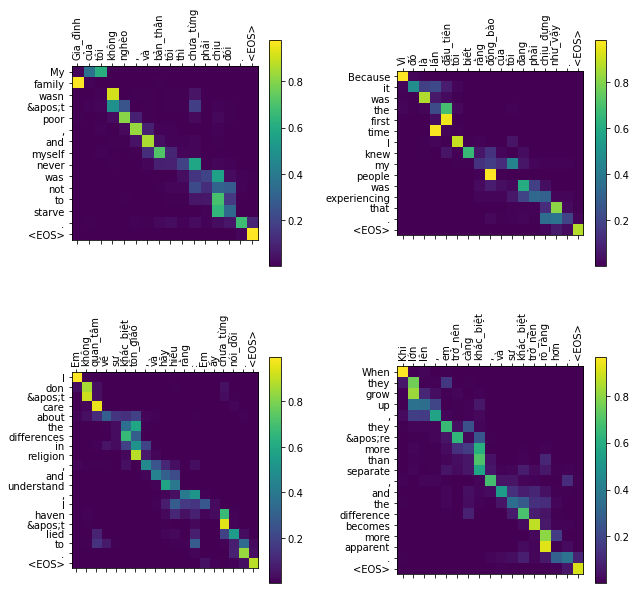

In [199]:
index = [5,10,98,117]
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1, 5):
    idx = index[i-1]
    aaa = np.array(atten_weight_list[idx])
    ax = fig.add_subplot(2, 2, i)
    cax = ax.matshow(aaa)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + src_sents[idx].split(' ')  +['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + tgt_pred_sents_sacre[idx].split(' ')+['<EOS>'])
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
